In [13]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,8)

import os

import astropy
from astropy import log
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
CCD_KWARGS = {'unit': 'adu'}

OBJ_COORD = SkyCoord(339.94692562872, 45.14639621713, unit=u.deg, frame=ICRS)

# Coordinates obtained from SIMBAD Gaia DR3 measurements
	# Except for 2MASS object, coord.s taken from 2MASS observations
# TODO: use 332 as main reference star
	# had least amount of OOB errors when looking through all the images
	# maybe don't use images where reference star is OOB? would only amount to removing ~5 images total
REF_OBJS_COORDS = {	
	"TYC 3620-332-1": SkyCoord(339.88604238078, 45.12830357108, unit=u.deg, frame=ICRS), # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898038&Name=TYC%203620-332-1
	"TYC 3620-254-1": SkyCoord(339.99378670432, 45.10213449513, unit=u.deg, frame=ICRS), # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898031&Name=TYC%203620-254-1
    "2MASS J22395194+4511599": SkyCoord(339.966424, 45.199989, unit=u.deg, frame=ICRS) # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%4021392858&Name=2MASS%20J22395194%2b4511599
}

In [2]:
PLATE_SOLVED_DIRS = []
for f in os.listdir(OBJ_DATA_DIR):
    if f == '2022-10-22':
        continue # skip october 22, doesn't look like useful observations

    if f.startswith("2022") and os.path.isdir(f"{OBJ_DATA_DIR}/{f}"): # is an observation directory
        PLATE_SOLVED_DIRS.append(f"{OBJ_DATA_DIR}/{f}/corrected/solved-fits")
PLATE_SOLVED_DIRS

['/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-10/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-21/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-27/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-05/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-26/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-07/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-08/corrected/solved-fits',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-09/corrected/solved-fits']

In [8]:
# brute force; move all of the solved fits file to a single folder for ease of use
import shutil

PS_SYMLINK_DIR = f"{OBJ_DATA_DIR}/solved-fits-all"

if not os.path.exists(PS_SYMLINK_DIR):
	os.mkdir(PS_SYMLINK_DIR)

for psd in PLATE_SOLVED_DIRS:
	for f in os.listdir(psd):
		sourcePath = f"{psd}/{f}"
		destPath = f"{OBJ_DATA_DIR}/solved-fits-all/{f}"
		shutil.move(sourcePath, destPath)

In [16]:
import ccdproc

obsvImages = ccdproc.ImageFileCollection(PS_SYMLINK_DIR)

In [17]:
from tqdm import tqdm

log.setLevel('ERROR')

oobTracker = {k:[] for k,_ in REF_OBJS_COORDS.items()}

for img, img_fname in tqdm(obsvImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True)):
	for refSkyName, refSkyCoord in REF_OBJS_COORDS.items():
		try:
			refPxCoord = refSkyCoord.to_pixel(img.wcs)
			refCenterX, refCenterY = refPxCoord[0].item(), refPxCoord[1].item()
			
			testOobX = refCenterX < 0 or refCenterX > img.header['NAXIS1']
			testOobY = refCenterY < 0 or refCenterY > img.header['NAXIS2']
			if testOobX or testOobY:
				oobTracker[refSkyName].append(img_fname)
		except:
			print(img_fname)
			raise

log.setLevel('WARNING')

oobTracker

1481it [00:46, 31.85it/s]


{'TYC 3620-332-1': ['bdf_2022-10-21_23-59-52_60.00.fits',
  'bdf_2022-10-22_00-57-30_60.00.fits',
  'bdf_2022-10-22_00-58-31_60.00.fits',
  'bdf_2022-10-22_00-59-31_60.00.fits',
  'bdf_2022-11-27_00-44-52__60.00s_0000.fits',
  'bdf_2022-12-10_00-08-14.fits'],
 'TYC 3620-254-1': ['bdf_2022-10-21_23-55-50_60.00.fits',
  'bdf_2022-10-21_23-57-51_60.00.fits',
  'bdf_2022-10-21_23-58-51_60.00.fits',
  'bdf_2022-10-21_23-59-52_60.00.fits',
  'bdf_2022-10-22_00-57-30_60.00.fits',
  'bdf_2022-10-22_00-58-31_60.00.fits',
  'bdf_2022-10-22_00-59-31_60.00.fits',
  'bdf_2022-11-27_00-44-52__60.00s_0000.fits',
  'bdf_2022-12-06_21-02-07_0000.fits',
  'bdf_2022-12-06_21-03-07_0000.fits',
  'bdf_2022-12-06_21-04-08_0000.fits',
  'bdf_2022-12-06_21-05-08_0000.fits',
  'bdf_2022-12-06_21-06-08_0000.fits',
  'bdf_2022-12-06_21-07-08_0000.fits',
  'bdf_2022-12-06_21-08-09_0000.fits',
  'bdf_2022-12-06_21-09-09_0000.fits',
  'bdf_2022-12-06_21-11-09_0000.fits',
  'bdf_2022-12-06_21-12-10_0000.fits',
  'bd

bdf_2022-12-06_22-32-10.fits
TYC 3620-332-1: (1283.0828840903469, 854.5564481809064)
TYC 3620-254-1: (526.7134063391411, 1170.5066698534151)
2MASS J22395194+4511599: (659.999665712909, 162.72217640853353)


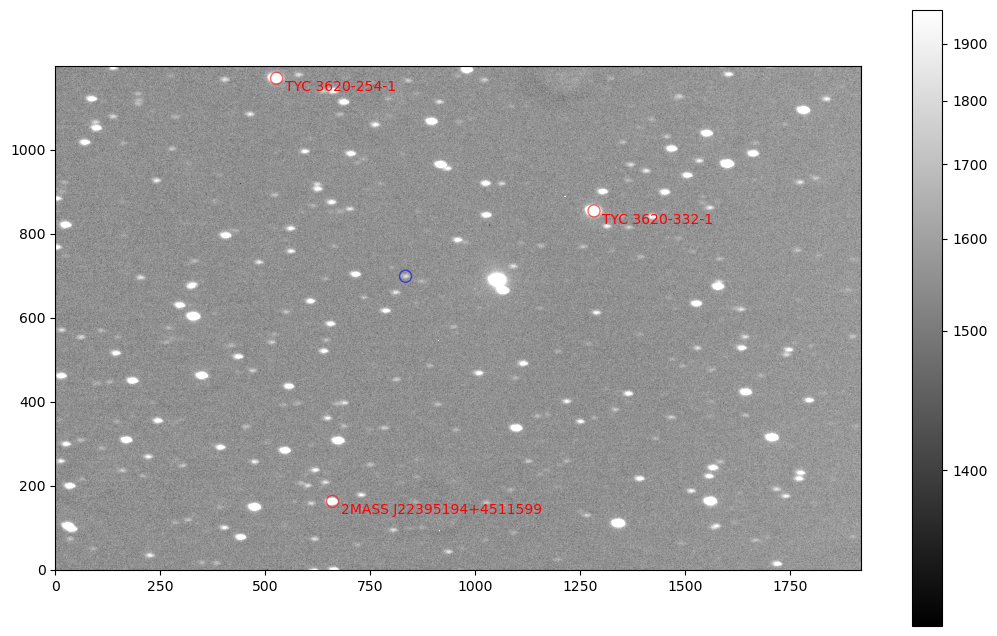

KeyboardInterrupt: Interrupted by user

In [37]:
from lmfit.models import GaussianModel, ConstantModel
from lmfit import report_fit
from IPython.display import clear_output
from astropy.visualization import SqrtStretch, ImageNormalize, ZScaleInterval

log.setLevel('ERROR')

for img, img_fname in obsvImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	print(img_fname)
	objPxCoord = OBJ_COORD.to_pixel(img.wcs)
	objCenterX, objCenterY = round(objPxCoord[0].item()), round(objPxCoord[1].item())

	norm = ImageNormalize(img, interval=ZScaleInterval(), stretch=SqrtStretch())
	plt.imshow(img.data, cmap='gray', origin='lower', norm=norm)
	plt.colorbar()

	plt.scatter(objCenterX, objCenterY, marker='.', alpha=0.6, edgecolors='blue', facecolors='none', s=300)
	for refSkyName, refSkyCoord in REF_OBJS_COORDS.items():
		refPxCoord = refSkyCoord.to_pixel(img.wcs)
		refCenterX, refCenterY = refPxCoord[0].item(), refPxCoord[1].item()
		print(f"{refSkyName}: ({refCenterX}, {refCenterY})")
		plt.scatter(refCenterX, refCenterY, marker='.', alpha=0.6, edgecolors='red', facecolors='none', s=300)
		plt.text(refCenterX + 20, refCenterY - 30, refSkyName, color='red')
	
	plt.show()
	input()
	clear_output()
	plt.clf()